In [ ]:
import os
import re
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

## Dataset Preparation

In [ ]:

# =============== Preprocessing Functions ===============
def read_corpus(data_path, lang='eng', type='dev'):
    """Read sequences from a corpus file."""
    file_path = os.path.join(data_path, f"{lang}.{type}")
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

def load_dataset(foldername):
    """Load English and Urdu datasets from specified folder."""
    eng_dev = read_corpus(foldername, 'eng_Latn', 'dev')
    urdu_dev = read_corpus(foldername, 'urd_Arab', 'dev')
    eng_devtest = read_corpus(foldername, 'eng_Latn', 'devtest')
    urdu_devtest = read_corpus(foldername, 'urd_Arab', 'devtest')
    return np.array(eng_dev + eng_devtest), np.array(urdu_dev + urdu_devtest)

def clean_urdu(text):
    """Clean and normalize Urdu text."""
    text = re.sub(r"([۔،؟!])", r" \1 ", text)
    text = re.sub(r"[^ا-یءٔ،۔!?0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def clean_english(text):
    """Clean and normalize English text."""
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-z0-9.,!?'\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def clean_corpus(corpus, lang='en'):
    """Clean a corpus based on the language."""
    if lang == 'en': return [clean_english(t) for t in corpus]
    elif lang == 'ur': return [clean_urdu(t) for t in corpus]

def clean_pairs(eng_texts, ur_texts, max_en=45, max_ur=55):
    """Filter text pairs exceeding the maximum length."""
    cleaned_en, cleaned_ur = [], []; 
    for en, ur in zip(eng_texts, ur_texts):
        if len(en.split()) > max_en-2 or len(ur.split()) > max_ur-2: continue
        cleaned_en.append(en); cleaned_ur.append(ur) 
    return cleaned_en, cleaned_ur
            
# =============== Vocabulary and Tokenization ===============
special_tokids = list(range(4))
class Vocab:
    """Vocabulary for text tokenization and detokenization."""
    def __init__(self, texts, min_freq=1):
        self.token2id = {"<pad>": 0, "<unk>": 1, "<sos>": 2, "<eos>": 3}
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.build_vocab(texts, min_freq)

    def build_vocab(self, texts, min_freq):
        """Build vocabulary based on token frequency."""
        counter = Counter(token for text in texts for token in text.split())
        for token, freq in counter.items():
            if freq >= min_freq:
                idx = len(self.token2id)
                self.token2id[token] = idx
                self.id2token[idx] = token

    def encode(self, text):
        """Convert text to a list of token IDs."""
        return [self.token2id.get(token, self.token2id["<unk>"]) for token in text.split()]

    def decode(self, ids, clean=True):
        """Convert token IDs back to text."""
        if isinstance(ids, torch.Tensor): ids = ids.tolist()
        if not clean: return " ".join([self.id2token.get(idx, "<unk>") for idx in ids]) 
        return " ".join([self.id2token.get(idx, "<unk>") for idx in ids if idx not in special_tokids])

    def get_id(self, token):
        """Get the ID of a token."""
        return self.token2id.get(token, self.token2id["<unk>"])

    def tokenize(self, texts):
        """Tokenize and pad text sequences."""
        tokens = [self.encode(text) for text in texts]
        max_len = max(len(token_seq) for token_seq in tokens) + 2; 
        start, end, pad = self.get_id('<sos>'), self.get_id('<eos>'), self.get_id('<pad>')
        
        tokenized = [[start] + token_seq + [end] for token_seq in tokens] 
        tokenized = [self.pad_sequence(token_seq, max_len, pad) for token_seq in tokenized]
        return torch.tensor(tokenized, dtype=torch.long)

    def pad_sequence(self, seq, max_len, pad_token=0):
        """Pad a sequence to the maximum length."""
        return seq + [pad_token] * (max_len - len(seq))


# =============== Dataset ===============
class TranslationDataset(Dataset):
    """Dataset for handling translation tasks."""
    def __init__(self, src_tokens, tgt_tokens, src_vocab, tgt_vocab):
        self.src_texts = src_tokens
        self.tgt_texts = tgt_tokens

    def __len__(self):
        return len(self.src_texts)

    def __getitem__(self, idx):
        """Get a source-target pair."""
        src_seq = self.src_texts[idx]
        tgt_seq = self.tgt_texts[idx]
        return src_seq, tgt_seq


# =============== Training Configuration ===============
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Dara variables and paths
data_path = "/kaggle/input/uren-corpus"
batch_size = 256
min_freq = 1

# Load and clean data
eng_texts, ur_texts = load_dataset(data_path)
eng_texts = clean_corpus(eng_texts, lang='en')
ur_texts = clean_corpus(ur_texts, lang='ur')
eng_texts,ur_texts = clean_pairs(eng_texts, ur_texts)
print("Number of Sequences:", len(eng_texts))

# Create vocabularies and Tokenizers
eng_vocab = Vocab(eng_texts, min_freq)
ur_vocab = Vocab(ur_texts, min_freq)

# Tokenize and pad sequences
ur_texts = ur_vocab.tokenize(ur_texts)
eng_texts = eng_vocab.tokenize(eng_texts)

# Split data into train, validation, and test sets
ur_train, ur_temp, en_train, en_temp = train_test_split(ur_texts, eng_texts, test_size=0.3, random_state=42)
ur_test, ur_val, en_test, en_val = train_test_split(ur_temp, en_temp, test_size=0.5, random_state=42)

# Create datasets and data loaders
train_set = TranslationDataset(ur_train, en_train, ur_vocab, eng_vocab)
val_set = TranslationDataset(ur_val, en_val, ur_vocab, eng_vocab)
test_set = TranslationDataset(ur_test, en_test, ur_vocab, eng_vocab)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Number of Sequences: 1958


## Custom Modules

In [97]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# =============== Custom RNN Implementation ===============
class CustomRNN(nn.Module):
    """Custom implementation of a multi-layer RNN"""
    def __init__(self, input_size, hidden_size, num_layers=1, nonlinearity='tanh', batch_first=False):
        super(CustomRNN, self).__init__()
        
        # Model parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.nonlinearity = nonlinearity
        self.batch_first = batch_first
        
        # Set activation function
        if nonlinearity == 'tanh': self.activation = nn.Tanh()
        elif nonlinearity == 'relu': self.activation = nn.ReLU()
        else: raise ValueError(f"Unsupposed Activation Function {nonlinearity}")

        # Initialize weights and biases for each layer
        self.weight_ih = nn.ParameterList([
            nn.Parameter(torch.Tensor(hidden_size, input_size if layer == 0 else hidden_size))
            for layer in range(num_layers)
        ])        
        self.weight_hh = nn.ParameterList([
            nn.Parameter(torch.Tensor(hidden_size, hidden_size))
            for _ in range(num_layers)
        ])
        self.bias_ih = nn.ParameterList([
            nn.Parameter(torch.Tensor(hidden_size))
            for _ in range(num_layers)
        ])            
        self.bias_hh = nn.ParameterList([
            nn.Parameter(torch.Tensor(hidden_size))
            for _ in range(num_layers)
        ])
        
        self._reset_parameters()
    
    def _reset_parameters(self):
        # Initialize parameters uniformly
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.weight_ih:
            nn.init.uniform_(weight, -stdv, stdv)
        for weight in self.weight_hh:
            nn.init.uniform_(weight, -stdv, stdv)
        for bias in self.bias_ih:
            nn.init.uniform_(bias, -stdv, stdv)
        for bias in self.bias_hh:
            nn.init.uniform_(bias, -stdv, stdv)
    
    def forward(self, x, h0=None):
        # Transpose input if batch_first is True
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        # Initialize hidden states if not provided        
        if h0 is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, 
                              device=x.device, dtype=x.dtype)

        
        # Process each time step
        output, hn = [], []  # Store outputs and hidden states
        for layer in range(self.num_layers):
            layer_h0 = h0[layer]
            layer_state, layer_output = layer_h0, []
            layer_input = x if layer == 0 else output[-1]
            
            for t in range(seq_len):
                # Forward pass: Compute input-to-hidden and hidden-to-hidden contributions
                ih = torch.matmul(layer_input[t], self.weight_ih[layer].t())  # input-to-hidden
                hh = torch.matmul(layer_state, self.weight_hh[layer].t())  # hidden-to-hidden
                ih += self.bias_ih[layer]
                hh += self.bias_hh[layer]
                layer_state = self.activation(ih + hh)                
                layer_output.append(layer_state)  # Store last hidden state
                
            # Convert to tensor
            layer_output = torch.stack(layer_output)            
            output.append(layer_output)
            hn.append(layer_output[-1])
        
        # Final output processing
        output = output[-1]
        hn = torch.stack(hn)
        
        # Restore batch dimension if batch_first was True
        if self.batch_first:
            output = output.transpose(0, 1)
        return output, hn

# =============== Custom LSTM Implementation ===============
class CustomLSTMCell(nn.Module):
    """A custom implementation of single LSTM cell."""
    def __init__(self, input_size, hidden_size, proj_size):
        super(CustomLSTMCell, self).__init__()
        
        # Initialize LSTM gates weights and biases
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))  # Input-hidden weights
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))  # Hidden-hidden weights
        self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))  # Input-hidden bias
        self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))  # Hidden-hidden bias
        
        # Projection layer (optional)
        self.weight_pr = nn.Parameter(torch.randn(proj_size, hidden_size)) if proj_size > 0 else None  # Projection layer
        self._init_parameters()

    def _init_parameters(self):
        # Xavier initialization for weights and zero for biases
        nn.init.xavier_uniform_(self.weight_ih)
        nn.init.xavier_uniform_(self.weight_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)

    def forward(self, x_t, h_t, c_t):
        # Compute all gate values
        gates = F.linear(x_t, self.weight_ih, self.bias_ih) + \
                F.linear(h_t, self.weight_hh, self.bias_hh)        

        # Split gates and apply activations
        i_t, f_t, g_t, o_t = gates.chunk(4, dim=-1)
        i_t, f_t, o_t = torch.sigmoid(i_t), torch.sigmoid(f_t), torch.sigmoid(o_t)
        g_t = torch.tanh(g_t)

        # Compute next cell state and hidden state
        c_next = f_t * c_t + i_t * g_t
        h_next = o_t * torch.tanh(c_next)

        # Apply projection if defined
        if self.weight_pr is not None:
            h_next = F.linear(h_next, self.weight_pr)
        
        return h_next, c_next
    
class CustomLSTM(nn.Module):
    """Custom LSTM implementation with support for multiple layers"""
    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=False, proj_size=0, dropout=0):
        super(CustomLSTM, self).__init__()

         # Model configuration
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first

        # Dropout layer (if needed)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        self.proj_size = proj_size if proj_size > 0 else hidden_size

        # Initialize LSTM layers
        self.layers = nn.ModuleList([ 
            CustomLSTMCell(
                input_size if i == 0 else self.hidden_size,
                hidden_size, 
                proj_size
            ) for i in range(num_layers)
        ])

    def forward(self, x, hx=None):
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, input_size = x.size()
        
        # Initialize hidden states if not provided
        if hx is None:
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        else: h_0, c_0 = hx

        output, h_n, c_n = [], [], []
        for layer_idx in range(self.num_layers):
            layer_input = x if layer_idx == 0 else output[-1]
            h_t, c_t = h_0[layer_idx], c_0[layer_idx]
            layer_output = []

            # Process each time step
            for t in range(seq_len):
                x_t = layer_input[t]
                
                # Use the LSTM cell to compute the hidden state and cell state
                h_next, c_next = self.layers[layer_idx](x_t, h_t, c_t)
                
                layer_output.append(h_next)
                h_t, c_t = h_next, c_next

            # Stack layer output and apply dropout for intermediate layers
            layer_output = torch.stack(layer_output)
            if self.dropout and layer_idx < self.num_layers - 1:
                layer_output = self.dropout(layer_output)
            
            output.append(layer_output)
            h_n.append(h_t)
            c_n.append(c_t)

        # Stack final outputs and states
        output = output[-1]  # Final layer output
        h_n = torch.stack(h_n)  # Final hidden states
        c_n = torch.stack(c_n)  # Final cell states
        
        # Restore batch_first format if needed
        if self.batch_first:
            output = output.transpose(0, 1)  # (batch_size, seq_len, hidden_size)
        
        return output, (h_n, c_n)

## RNN Translation Model

In [ ]:
# =============== Attention-based Encoder-Decoder Model ===============
class RNNEncoder(nn.Module):
    """Encoder module using a Custom RNN with embeddings and batch normalization."""
    def __init__(self, input_dim, emb_dim, hidden_dim, droprate=0.1):
        super().__init__()
        self.dropout = nn.Dropout(droprate)
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)
        self.rnn = CustomRNN(emb_dim, hidden_dim, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim)

    def forward(self, src):
        # Convert tokens to embeddings
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        # Pass through RNN and BatchNormalize
        outputs, hidden = self.rnn(embedded)
        outputs = self.bn(outputs.transpose(1, 2)).transpose(1, 2)
        return outputs, hidden

class Attention(nn.Module):
    """Attention mechanism to compute attention weights and context vectors."""
    def __init__(self, enc_dim, dec_dim, droprate=0.1):
        super().__init__()
        # Combine encoder and decoder states
        self.attn = nn.Linear(enc_dim + dec_dim, dec_dim)
        self.v = nn.Linear(dec_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.squeeze(0)
        seq_len = encoder_outputs.size(1)
        # Repeat decoder state for each sequence step
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) 
        # Reduce to scalar per step and normalize to probabilities
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)


class RNNDecoder(nn.Module):
    """Decoder module using a Custom RNN with attention and batch normalization."""
    def __init__(self, output_dim, emb_dim, hidden_dim, attention, droprate=0.1):
        super().__init__()
        self.output_dim = output_dim
        self.dropout = nn.Dropout(droprate)
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # self.rnn = nn.RNN(hidden_dim + emb_dim, hidden_dim, batch_first=True)
        self.rnn = CustomRNN(hidden_dim + emb_dim, hidden_dim, batch_first=True)        
        self.fc = nn.Linear(hidden_dim + hidden_dim + emb_dim, output_dim)
        # Combine hidden, context, and embedding
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.attention = attention

    def forward(self, input, hidden, encoder_outputs):
        # Convert tokens to embeddings
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        # Compute attention weights and Context vectors
        attn_weights = self.attention(hidden, encoder_outputs).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        # Concatenate embedding and context to rnn
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        output = self.bn(output.transpose(1, 2)).transpose(1, 2)
        output = self.fc(torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim=1))
        return output, hidden

class RNNSeq2Seq(nn.Module):
    """Attention-Based RNN Encoder-Decoder Sequence-to-sequence model"""
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.25):
        tgt_len = tgt.size(1)
        batch_size = src.size(0)
        tgt_vocab_size = self.decoder.output_dim  # Initialize output tensor
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = tgt[:, 0]  # Start token for decoder

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output  # Store current timestep output
            top1 = output.argmax(1)  # Get highest probability token
            input = tgt[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1
        return outputs

# =============== Inference ===============
block_tokens = [eng_vocab.get_id('<eos>'), eng_vocab.get_id('.')]

def translate_sentence(model, sentence, src_vocab, tgt_vocab, max_len=50):
    """Perform greedy decoding to translate a sentence."""
    model.train()
    tokens = src_vocab.encode(sentence)
    src_tensor = torch.tensor([tokens], dtype=torch.long).to(model.device)
    encoder_outputs, hidden = model.encoder(src_tensor)
    
    # Prepare inputs for Translation
    input = torch.tensor([tgt_vocab.get_id('<sos>')], dtype=torch.long).to(model.device)
    result = []  # Generated sequence from model
    for _ in range(max_len):
        output, hidden = model.decoder(input, hidden, encoder_outputs)
        logits = output.squeeze(1)  # Shape: (batch_size, vocab_size)
        # logits[:, block_tokens] = -float('inf')
        top1 = logits.argmax(1).item()
        # Stop Generation when <eos> token output
        if top1 == tgt_vocab.get_id('<eos>'): break
        result.append(top1)
        input = torch.tensor([top1], dtype=torch.long).to(model.device)
    return tgt_vocab.decode(result)

def translate_sentence_beam(model, sentence, src_vocab, tgt_vocab, beam_width=3, max_len=50):
    """Perform beam search decoding to translate a sentence."""
    model.eval()
    tokens = src_vocab.encode(sentence)
    src_tensor = torch.tensor([tokens], dtype=torch.long).to(model.device)
    encoder_outputs, hidden = model.encoder(src_tensor)
    # Prepare sequence beams for Translation
    beams = [(torch.tensor([tgt_vocab.get_id('<sos>')], dtype=torch.long).to(model.device), 0, hidden)]
    results = []
    for _ in range(max_len):
        new_beams = []
        # Generate sequences from model
        for seq, score, hidden in beams:
            input = seq[-1].unsqueeze(0)
            output, hidden = model.decoder(input, hidden, encoder_outputs)
            probs = torch.softmax(output, dim=-1).squeeze(0)
            top_probs, top_ids = probs.topk(beam_width)
            
            # Update Beams with new token preducitons 
            for prob, idx in zip(top_probs, top_ids):
                new_seq = torch.cat([seq, idx.unsqueeze(0)])
                new_beams.append((new_seq, score + prob.item(), hidden))
        
        # keep Track of k best sequences
        new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
        beams = [beam for beam in new_beams if beam[0][-1].item() != tgt_vocab.get_id('<eos>')]

        results.extend([beam for beam in new_beams if beam[0][-1].item() == tgt_vocab.get_id('<eos>')])
        if not beams: break

    if results: return tgt_vocab.decode(results[0][0])
    else: return tgt_vocab.decode(beams[0][0])

## LSTM Translation Model

In [ ]:
# =============== Attention-based Encoder-Decoder Model ===============
class LSTMEncoder(nn.Module):
    """Encoder module using a Custom LSTM with embeddings and batch normalization."""    
    def __init__(self, input_dim, emb_dim, hidden_dim, droprate=0.1):
        super().__init__()
        self.dropout = nn.Dropout(droprate)
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = CustomLSTM(emb_dim, hidden_dim, batch_first=True) 
        self.bn = nn.BatchNorm1d(hidden_dim)

    def forward(self, src):
        # Convert tokens to embeddings
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        # Pass through RNN and BatchNormalize
        outputs, (hidden, cell) = self.rnn(embedded)
        outputs = self.bn(outputs.transpose(1, 2)).transpose(1, 2)
        return outputs, (hidden, cell)

class LSTMDecoder(nn.Module):
    """Decoder module using a Custom LSTM with attention and batch normalization."""
    def __init__(self, output_dim, emb_dim, hidden_dim, attention, droprate=0.1):
        super().__init__()
        self.output_dim = output_dim
        self.dropout = nn.Dropout(droprate)
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = CustomLSTM(hidden_dim + emb_dim, hidden_dim, batch_first=True)        
        self.fc = nn.Linear(hidden_dim + hidden_dim + emb_dim, output_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.attention = attention

    def forward(self, input, hidden, encoder_outputs):
        # Convert tokens to embeddings
        input = input.unsqueeze(1)
        hidden, cell = hidden
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        # Compute attention weights and Context vectors
        attn_weights = self.attention(hidden[0], encoder_outputs).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        # Concatenate embedding and context, input to LSTM
        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        output = self.bn(output.transpose(1, 2)).transpose(1, 2)
        output = self.fc(torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim=1))
        return output, (hidden, cell)

class LSTMSeq2Seq(nn.Module):
    """Attention-Based RNN Encoder-Decoder Sequence-to-sequence model"""
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        tgt_len = tgt.size(1)
        batch_size = src.size(0)
        tgt_vocab_size = self.decoder.output_dim  # Initialize output tensor
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        encoder_outputs, (hidden, cell) = self.encoder(src)
        input = tgt[:, 0]

        for t in range(1, tgt_len):
            output, (hidden, cell) = self.decoder(input, (hidden, cell), encoder_outputs)
            outputs[:, t] = output  # Store current timestep output
            top1 = output.argmax(1)  # Get highest probability token
            input = tgt[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1
        return outputs

## Dataset and Model Testing

In [ ]:
# =============== Test Code for Vocabulary and Dataset ===============

def test_vocab_and_dataset():
    # Test Vocabulary
    print("Testing Vocabulary Sizes...")
    print("English Vocabulary:", len(eng_vocab.token2id))
    print("Urdu Vocabulary:", len(ur_vocab.token2id))
    
    # Test Vocabulary
    print("\nTesting Vocabulary...")
    test_sentence_eng = clean_english("This is a test sentence.")
    test_sentence_ur = clean_urdu("یہ ایک تجربات جملہ ہے۔")
    encoded_eng = eng_vocab.encode(test_sentence_eng)
    encoded_ur = ur_vocab.encode(test_sentence_ur)
    print("Encoded English:", encoded_eng)
    print("Decoded English:", eng_vocab.decode(encoded_eng))
    print("Encoded Urdu:", encoded_ur)
    print("Decoded Urdu:", ur_vocab.decode(encoded_ur))
    
    # Ensure padding works
    print("\nTesting Tokenization and Padding...")
    tokenized_eng = eng_vocab.tokenize([test_sentence_eng])
    tokenized_ur = ur_vocab.tokenize([test_sentence_ur])
    print("Padded English Tokens:", tokenized_eng)
    print("Padded Urdu Tokens:", tokenized_ur)
    
    # Test Dataset
    print("\nTesting Dataset...")
    dataset_sample = train_set[0]  # Fetch one sample from train_set
    print("Source Sequence (Urdu):", dataset_sample[0])
    print("Target Sequence (English):", dataset_sample[1])

    # Ensure DataLoader works
    print("\nTesting DataLoader...")
    for batch in train_loader:
        src_batch, tgt_batch = batch
        print("Source Batch Shape:", src_batch.shape)
        print("Target Batch Shape:", tgt_batch.shape)
        break  # Test one batch only

def test_translation_dataset():
    print("\nTesting TranslationDataset...")
    # Check length
    dataset_length = len(train_set)
    print("Dataset Length:", dataset_length)

    # Fetch a sample and validate source and target
    sample_idx = 0
    src_seq, tgt_seq = train_set[sample_idx]
    print("Source Sequence Shape (Urdu):", src_seq.shape)
    print("Source Decoded (Urdu):", ur_vocab.decode(src_seq))
    print("Source Sequence (Urdu):", src_seq)
    print("Target Sequence Shape (English):", tgt_seq.shape)
    print("Target Decoded (English):", eng_vocab.decode(tgt_seq))
    print("Target Sequence (English):", tgt_seq)

# Execute the test
test_vocab_and_dataset()
test_translation_dataset()

In [ ]:
# =============== Test Code for Dataset and Seq2Seq Model ===============
def test_encoder():
    print("\nTesting Encoder...")
    src_sample = next(iter(train_loader))[0]  # Fetch source batch
    print("Source Batch Shape:", src_sample.shape)
    encoder = RNNEncoder(input_dim=len(ur_vocab.token2id), emb_dim=256, hidden_dim=512).to(device)
    encoder_outputs, hidden = encoder(src_sample.to(device))
    print("Encoder Outputs Shape:", encoder_outputs.shape)
    print("Encoder Hidden State Shape:", hidden.shape)

def test_attention():
    print("\nTesting Attention...")
    attention = Attention(enc_dim=512, dec_dim=512).to(device)
    hidden = torch.randn(64, 512).to(device)  # Mock hidden state (batch_size=64, hidden_dim=512)
    encoder_outputs = torch.randn(64, 50, 512).to(device)  # Mock encoder outputs (seq_len=10)
    attn_weights = attention(hidden, encoder_outputs)
    print("Attention Weights Shape:", attn_weights.shape)

def test_decoder():
    print("\nTesting Decoder...")
    decoder = RNNDecoder(output_dim=len(eng_vocab.token2id), emb_dim=256, hidden_dim=512, attention=Attention(512, 512)).to(device)
    input_token = torch.tensor([eng_vocab.get_id("<sos>")]*64).to(device)  # Mock input (batch_size=64)
    hidden = torch.randn(1, 64, 512).to(device)
    encoder_outputs = torch.randn(64, 10, 512).to(device)
    output, hidden = decoder(input_token, hidden, encoder_outputs)
    print("Decoder Output Shape:", output.shape)
    print("Decoder Hidden State Shape:", hidden.shape)

def test_seq2seq():
    print("\nTesting Seq2Seq Model...")
    encoder = Encoder(input_dim=len(ur_vocab.token2id), emb_dim=256, hidden_dim=512).to(device)
    attention = Attention(enc_dim=512, dec_dim=512).to(device)
    decoder = Decoder(output_dim=len(eng_vocab.token2id), emb_dim=256, hidden_dim=512, attention=attention).to(device)
    seq2seq = Seq2Seq(encoder, decoder, device).to(device)

    src_sample, tgt_sample = next(iter(train_loader))  # Fetch source and target batches
    print("Source Sample Shape:", src_sample.shape)
    print("Target Sample Shape:", tgt_sample.shape)

    outputs = seq2seq(src_sample.to(device), tgt_sample.to(device))
    print("Seq2Seq Outputs Shape:", outputs.shape)


# Execute tests
test_encoder()
test_attention()
test_decoder()
test_seq2seq()

In [ ]:
# # import matplotlib.pyplot as plt

# # # Example array of sequences
# # sequences = ur_texts
# # # Calculate lengths of sequences
# # lengths = [len(seq.split()) for seq in sequences]

# # # Plot distribution of lengths
# # plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1), edgecolor='black')
# # plt.xlabel('Sequence Length')
# # plt.ylabel('Frequency')
# # plt.title('Distribution of Sequence Lengths')
# # plt.show()

# # Data Loading
# # English Cut of 40, Urdu 50
# eng_texts, ur_texts = load_dataset(data_path)
# ur_texts = clean_corpus(ur_texts, lang='ur')
# print("Before", len(ur_texts))
# ur_texts = [text for text in ur_texts if len(text.split())>8]
# print("After", len(ur_texts))
# # for seq in eng_texts:
# #     for word in seq.split():
# #         if word == 'sentence':
# #             print (seq)
# #             break
# # eng_vocab.get_id('sentence')

## RNN Model Training

In [ ]:
!pip install sacrebleu
import sacrebleu

# Creates Hypothesis Sequences
def decode_batch(batch, tokenizer):
    return [tokenizer.decode(sequence) for sequence in batch]

# Creates Reference Sequences
def create_ref(data_loader, tokenizer):
    references = []
    for _, target_batch in data_loader:
        decoded_batch = decode_batch(target_batch, tokenizer)
        references.extend([[ref] for ref in decoded_batch])
    return references
    
# Use sacrebleu to calculate bleu score 
def calculate_bleu(references, predictions):
    bleu = sacrebleu.corpus_bleu(predictions, references)
    return bleu.score

# Experimental Loss Functions for improving outputs
class LabelSmoothingLoss(nn.Module):
    """Label Smoothing reduces model confidence on frequent tokens"""
    def __init__(self, smoothing=0.1, ignore_index=None):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        vocab_size = pred.size(-1)  # Compute loss with smoothing
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        smooth_target = (1 - self.smoothing) * one_hot + self.smoothing / vocab_size

        if self.ignore_index is not None:
            mask = (target != self.ignore_index)
            pred = pred[mask]
            smooth_target = smooth_target[mask]

        # Sum loss across prediction comparisons
        loss = -torch.sum(smooth_target * torch.log_softmax(pred, dim=-1), dim=-1).mean()
        return loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, ignore_index=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred_prob = torch.softmax(pred, dim=-1)
        target_prob = pred_prob.gather(1, target.unsqueeze(1))

        if self.ignore_index is not None:
            mask = (target != self.ignore_index)
            pred_prob = pred_prob[mask]
            target_prob = target_prob[mask]
            target = target[mask]

        loss = -torch.mean((1 - target_prob) ** self.gamma * torch.log(target_prob))
        return loss

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device, references=None):
    """Train Seq2Seq model for one complete epoch"""
    model.train()
    epoch_loss = 0
    predictions = []
    tokenizer = eng_vocab   # Training Steps
    for batch_idx, (src, tgt) in enumerate(train_loader):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt)            # Generate Predictions
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)  # Ignore <sos> token
        tgt = tgt[:, 1:].reshape(-1)  # Ignore <sos> token
        loss = criterion(output, tgt)       # Calculate Loss
        loss.backward()         # Perform Backpropagation and gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()        # Update weights
        epoch_loss += loss.item()

        out_tokens = output.argmax(dim=1).tolist()
        predictions.extend(decode_batch([out_tokens], tokenizer))

    avg_train_loss = epoch_loss / len(train_loader)
    bleu_score = calculate_bleu(references, predictions)
    return avg_train_loss, bleu_score


def eval_epoch(model, val_loader, criterion, device, references=None):
    model.eval()  # Switch to evaluation mode
    val_loss = 0
    predictions = []
    tokenizer = eng_vocab
    with torch.no_grad():  # No gradient calculation during validation
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt)        # Generate Predictions
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)  # Ignore <sos> token
            tgt = tgt[:, 1:].reshape(-1)    # Ignore <sos> token
            loss = criterion(output, tgt)   # Compute Loss
            val_loss += loss.item()
    
            out_tokens = output.argmax(dim=1).tolist()
            predictions.extend(decode_batch([out_tokens], tokenizer))

    avg_val_loss = val_loss / len(val_loader)
    bleu_score = calculate_bleu(references, predictions)
    return avg_val_loss, bleu_score
    
def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device, log_interval=3):
    # Dictionary to store losses for each epoch
    loss_log = {'train_loss': [], 'val_loss': [], 'train_bleu':[], 'val_bleu':[]}
    train_ref = create_ref(train_loader, eng_vocab)
    val_ref = create_ref(val_loader, eng_vocab)
    
    for epoch in range(n_epochs):
        # Train for one complete epoch
        avg_train_loss, train_bleu = train_epoch(model, train_loader, optimizer, criterion, device, train_ref)
        loss_log['train_loss'].append(avg_train_loss)
        loss_log['train_bleu'].append(train_bleu)
        
        # Evaluate on entire validation set
        avg_val_loss, val_bleu = eval_epoch(model, val_loader, criterion, device, val_ref)
        loss_log['val_loss'].append(avg_val_loss)
        loss_log['val_bleu'].append(val_bleu)
        print(f"Epoch {epoch+1}/{n_epochs}  -  train_loss: {avg_train_loss:.4f} -",
             f'train_bleu: {train_bleu:.4f} - val_loss: {avg_val_loss:.4f} - val_bleu: {val_bleu:.4f}')

        if (epoch + 1) % log_interval == 0:
            df = pd.DataFrame(loss_log)
            df.to_csv(f'losses.csv', index=False)   # Log losses and bleu scores
            print(f"\nEpoch {epoch+1} losses and bleu scores saved to CSV.")
            sample_batch = next(iter(test_loader))[0]
            test_sentence = ur_vocab.decode(sample_batch[0])
            print(f"Sample Sentence:", test_sentence)   # Generate Sample translations
            print(f"Translation:",translate_sentence(model, test_sentence, ur_vocab, eng_vocab))
            print(f"Beam Translation:",translate_sentence_beam(model, test_sentence, ur_vocab, eng_vocab), '\n')

    # Save final loss log to CSV at the end of training
    df = pd.DataFrame(loss_log)
    df.to_csv('losses.csv', index=False)
    print("Final losses and bleu scores saved to CSV.")

In [102]:
# Training Configuration
embedding_dim = 32
hidden_dim = 128
n_epochs = 30
learning_rate = 1e-4

# Model Initialization
encoder = RNNEncoder(len(ur_vocab.token2id), embedding_dim, hidden_dim).to(device)
attention = Attention(hidden_dim, hidden_dim).to(device)
decoder = RNNDecoder(len(eng_vocab.token2id), embedding_dim, hidden_dim, attention).to(device)
model = RNNSeq2Seq(encoder, decoder, device).to(device)

# Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = criterion = FocalLoss(gamma=2, ignore_index=eng_vocab.get_id('<pad>'))

train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device, 5)

# Example Translation
test_sentence = "<eos> یہ ایک مثال ہے <sos>"
print("Translation:", translate_sentence(model, test_sentence, ur_vocab, eng_vocab))

Epoch 1/30  -  train_loss: 9.1268 - train_bleu: 0.0471 - val_loss: 9.1637 - val_bleu: 0.0395
Epoch 2/30  -  train_loss: 9.0952 - train_bleu: 0.0523 - val_loss: 9.1783 - val_bleu: 0.0451
Epoch 3/30  -  train_loss: 9.0483 - train_bleu: 0.0683 - val_loss: 9.1571 - val_bleu: 0.0521
Epoch 4/30  -  train_loss: 8.9891 - train_bleu: 0.0916 - val_loss: 9.1048 - val_bleu: 0.0591
Epoch 5/30  -  train_loss: 8.9130 - train_bleu: 0.0999 - val_loss: 9.0143 - val_bleu: 0.0749

Epoch 5 losses and bleu scores saved to CSV.
Sample Sentence: ڈی ڈ لینڈنگ اور اس ک بعد کی لڑایوں ک نتیج میں فرانس کا شمالی علاقہ زاد ہوگیا تھا ، لیکن اس کا جنوب اب بھی زاد نہیں ہوا تھا ۔
Translation: titles behind safe blissful qc seconds 6 warning germans throwing mri period overtopped ? agder focus coronavirusbased emerged in carbon social wave island's score stay possible spring youth catalan failures squeezed goals served will snowstorms emerged in carbon social wave arabic road aleisk dangerous than ranger end indicated ser

## RNN Model Evaluation

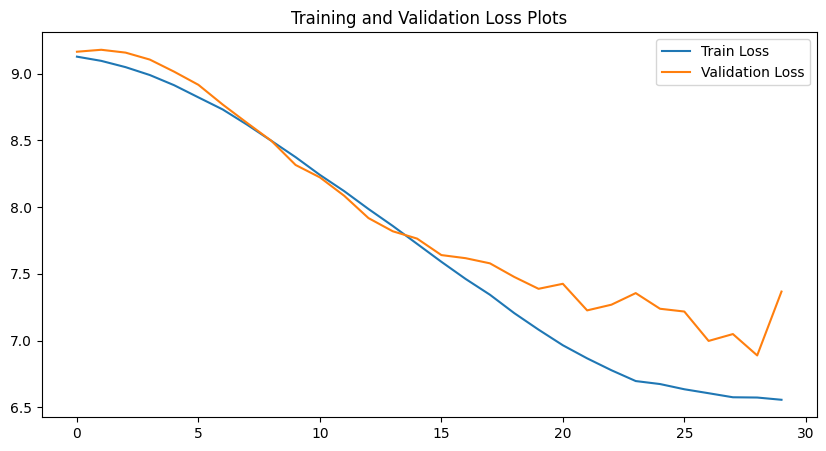

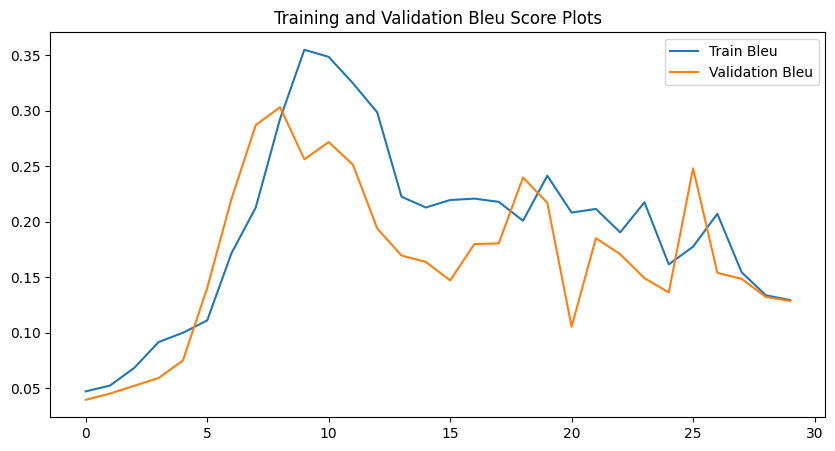

In [ ]:
# Plot Losses and Bleu Scores for Train and Validation sets 
training_logs = pd.read_csv('losses.csv')

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(training_logs['train_loss'], label='Train Loss')
plt.plot(training_logs['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss Plots")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(training_logs['train_bleu'], label='Train Bleu')
plt.plot(training_logs['val_bleu'], label='Validation Bleu')
plt.title("Training and Validation Bleu Score Plots")
plt.legend()
plt.show()

In [ ]:
# Evaluate Model on test set
test_ref = create_ref(test_loader, eng_vocab)
avg_val_loss, val_bleu = eval_epoch(model, val_loader, criterion, device, test_ref)
print(f"Test Set Loss: {avg_val_loss:.4f}")
print(f"Test Set Bleu Score: {val_bleu:.4f}")

Test Set Loss: 7.1990
Test Set Bleu Score: 0.0337


In [ ]:
# Generate a comparison table for train, test and val sets
train_ref = create_ref(train_loader, eng_vocab)
test_ref = create_ref(test_loader, eng_vocab)
val_ref = create_ref(val_loader, eng_vocab)

train_loss, train_bleu = eval_epoch(model, train_loader, criterion, device, train_ref)
test_loss, test_bleu = eval_epoch(model, test_loader, criterion, device, train_ref)
val_loss, val_bleu = eval_epoch(model, val_loader, criterion, device, test_ref)

metrics = {
    "Dataset": ["Train", "Test", "Validation"],
    "Loss": [train_loss, test_loss, val_loss],
    "BLEU Score": [train_bleu, test_bleu, val_bleu]
}

# Convert the dictionary into a pandas DataFrame
metrics_table = pd.DataFrame(metrics)
metrics_table

,Dataset,Loss,BLEU Score
0,Train,inf,0.135168
1,Test,7.19985,0.133831
2,Validation,7.22297,0.036556


## LSTM Model Training

In [ ]:
# Training Configuration
embedding_dim = 256
hidden_dim = 512
n_epochs = 30
learning_rate = 1e-4

# Model Initialization with LSTM Seq2Seq
encoder = LSTMEncoder(len(ur_vocab.token2id), embedding_dim, hidden_dim).to(device)
attention = Attention(hidden_dim, hidden_dim).to(device)
decoder = LSTMDecoder(len(eng_vocab.token2id), embedding_dim, hidden_dim, attention).to(device)
model = LSTMSeq2Seq(encoder, decoder, device).to(device)

# Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = criterion = LabelSmoothingLoss(smoothing=0.1, ignore_index=eng_vocab.get_id('<pad>'))

train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device, 5)

# Example Translation
test_sentence = "<eos> یہ ایک مثال ہے <sos>"
print("Translation:", translate_sentence(model, test_sentence, ur_vocab, eng_vocab))

## LSTM Model Evaluation

In [ ]:
# Generate a comparison table for train, test and val sets
training_logs = pd.read_csv('losses.csv')

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(training_logs['train_loss'], label='Train Loss')
plt.plot(training_logs['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss Plots")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(training_logs['train_bleu'], label='Train Bleu')
plt.plot(training_logs['val_bleu'], label='Validation Bleu')
plt.title("Training and Validation Bleu Score Plots")
plt.legend()
plt.show()

In [ ]:
# Evaluate Model on test set
test_ref = create_ref(test_loader, eng_vocab)
avg_val_loss, val_bleu = eval_epoch(model, val_loader, criterion, device, test_ref)
print(f"Test Set Loss: {avg_val_loss:.4f}")
print(f"Test Set Bleu Score: {val_bleu:.4f}")

In [ ]:
# Generate a comparison table for train, test and val sets
train_ref = create_ref(train_loader, eng_vocab)
test_ref = create_ref(test_loader, eng_vocab)
val_ref = create_ref(val_loader, eng_vocab)

train_loss, train_bleu = eval_epoch(model, train_loader, criterion, device, train_ref)
test_loss, test_bleu = eval_epoch(model, test_loader, criterion, device, train_ref)
val_loss, val_bleu = eval_epoch(model, val_loader, criterion, device, test_ref)

metrics = {
    "Dataset": ["Train", "Test", "Validation"],
    "Loss": [train_loss, test_loss, val_loss],
    "BLEU Score": [train_bleu, test_bleu, val_bleu]
}

# Convert the dictionary into a pandas DataFrame
metrics_table = pd.DataFrame(metrics)
metrics_table

## Blue Score using file

In [ ]:
# data = '''
# #!/usr/bin/env perl
# #
# # This file is part of moses.  Its use is licensed under the GNU Lesser General
# # Public License version 2.1 or, at your option, any later version.

# # $Id$
# use warnings;
# use strict;

# my $lowercase = 0;
# if ($ARGV[0] eq "-lc") {
#   $lowercase = 1;
#   shift;
# }

# my $stem = $ARGV[0];
# if (!defined $stem) {
#   print STDERR "usage: multi-bleu.pl [-lc] reference < hypothesis\n";
#   print STDERR "Reads the references from reference or reference0, reference1, ...\n";
#   exit(1);
# }

# $stem .= ".ref" if !-e $stem && !-e $stem."0" && -e $stem.".ref0";

# my @REF;
# my $ref=0;
# while(-e "$stem$ref") {
#     &add_to_ref("$stem$ref",\@REF);
#     $ref++;
# }
# &add_to_ref($stem,\@REF) if -e $stem;
# die("ERROR: could not find reference file $stem") unless scalar @REF;

# # add additional references explicitly specified on the command line
# shift;
# foreach my $stem (@ARGV) {
#     &add_to_ref($stem,\@REF) if -e $stem;
# }



# sub add_to_ref {
#     my ($file,$REF) = @_;
#     my $s=0;
#     if ($file =~ /.gz$/) {
# 	open(REF,"gzip -dc $file|") or die "Can't read $file";
#     } else { 
# 	open(REF,$file) or die "Can't read $file";
#     }
#     while(<REF>) {
# 	chomp;
# 	push @{$$REF[$s++]}, $_;
#     }
#     close(REF);
# }

# my(@CORRECT,@TOTAL,$length_translation,$length_reference);
# my $s=0;
# while(<STDIN>) {
#     chomp;
#     $_ = lc if $lowercase;
#     my @WORD = split;
#     my %REF_NGRAM = ();
#     my $length_translation_this_sentence = scalar(@WORD);
#     my ($closest_diff,$closest_length) = (9999,9999);
#     foreach my $reference (@{$REF[$s]}) {
# #      print "$s $_ <=> $reference\n";
#   $reference = lc($reference) if $lowercase;
# 	my @WORD = split(' ',$reference);
# 	my $length = scalar(@WORD);
#         my $diff = abs($length_translation_this_sentence-$length);
# 	if ($diff < $closest_diff) {
# 	    $closest_diff = $diff;
# 	    $closest_length = $length;
# 	    # print STDERR "$s: closest diff ".abs($length_translation_this_sentence-$length)." = abs($length_translation_this_sentence-$length), setting len: $closest_length\n";
# 	} elsif ($diff == $closest_diff) {
#             $closest_length = $length if $length < $closest_length;
#             # from two references with the same closeness to me
#             # take the *shorter* into account, not the "first" one.
#         }
# 	for(my $n=1;$n<=4;$n++) {
# 	    my %REF_NGRAM_N = ();
# 	    for(my $start=0;$start<=$#WORD-($n-1);$start++) {
# 		my $ngram = "$n";
# 		for(my $w=0;$w<$n;$w++) {
# 		    $ngram .= " ".$WORD[$start+$w];
# 		}
# 		$REF_NGRAM_N{$ngram}++;
# 	    }
# 	    foreach my $ngram (keys %REF_NGRAM_N) {
# 		if (!defined($REF_NGRAM{$ngram}) ||
# 		    $REF_NGRAM{$ngram} < $REF_NGRAM_N{$ngram}) {
# 		    $REF_NGRAM{$ngram} = $REF_NGRAM_N{$ngram};
# #	    print "$i: REF_NGRAM{$ngram} = $REF_NGRAM{$ngram}<BR>\n";
# 		}
# 	    }
# 	}
#     }
#     $length_translation += $length_translation_this_sentence;
#     $length_reference += $closest_length;
#     for(my $n=1;$n<=4;$n++) {
# 	my %T_NGRAM = ();
# 	for(my $start=0;$start<=$#WORD-($n-1);$start++) {
# 	    my $ngram = "$n";
# 	    for(my $w=0;$w<$n;$w++) {
# 		$ngram .= " ".$WORD[$start+$w];
# 	    }
# 	    $T_NGRAM{$ngram}++;
# 	}
# 	foreach my $ngram (keys %T_NGRAM) {
# 	    $ngram =~ /^(\d+) /;
# 	    my $n = $1;
#             # my $corr = 0;
# #	print "$i e $ngram $T_NGRAM{$ngram}<BR>\n";
# 	    $TOTAL[$n] += $T_NGRAM{$ngram};
# 	    if (defined($REF_NGRAM{$ngram})) {
# 		if ($REF_NGRAM{$ngram} >= $T_NGRAM{$ngram}) {
# 		    $CORRECT[$n] += $T_NGRAM{$ngram};
#                     # $corr =  $T_NGRAM{$ngram};
# #	    print "$i e correct1 $T_NGRAM{$ngram}<BR>\n";
# 		}
# 		else {
# 		    $CORRECT[$n] += $REF_NGRAM{$ngram};
#                     # $corr =  $REF_NGRAM{$ngram};
# #	    print "$i e correct2 $REF_NGRAM{$ngram}<BR>\n";
# 		}
# 	    }
#             # $REF_NGRAM{$ngram} = 0 if !defined $REF_NGRAM{$ngram};
#             # print STDERR "$ngram: {$s, $REF_NGRAM{$ngram}, $T_NGRAM{$ngram}, $corr}\n"
# 	}
#     }
#     $s++;
# }
# my $brevity_penalty = 1;
# my $bleu = 0;

# my @bleu=();

# for(my $n=1;$n<=4;$n++) {
#   if (defined ($TOTAL[$n])){
#     $bleu[$n]=($TOTAL[$n])?$CORRECT[$n]/$TOTAL[$n]:0;
#     # print STDERR "CORRECT[$n]:$CORRECT[$n] TOTAL[$n]:$TOTAL[$n]\n";
#   }else{
#     $bleu[$n]=0;
#   }
# }

# if ($length_reference==0){
#   printf "BLEU = 0, 0/0/0/0 (BP=0, ratio=0, hyp_len=0, ref_len=0)\n";
#   exit(1);
# }

# if ($length_translation<$length_reference) {
#   $brevity_penalty = exp(1-$length_reference/$length_translation);
# }
# $bleu = $brevity_penalty * exp((my_log( $bleu[1] ) +
# 				my_log( $bleu[2] ) +
# 				my_log( $bleu[3] ) +
# 				my_log( $bleu[4] ) ) / 4) ;
# printf "BLEU = %.2f, %.1f/%.1f/%.1f/%.1f (BP=%.3f, ratio=%.3f, hyp_len=%d, ref_len=%d)\n",
#     100*$bleu,
#     100*$bleu[1],
#     100*$bleu[2],
#     100*$bleu[3],
#     100*$bleu[4],
#     $brevity_penalty,
#     $length_translation / $length_reference,
#     $length_translation,
#     $length_reference;


# print STDERR "It is not advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.\n";

# sub my_log {
#   return -9999999999 unless $_[0];
#   return log($_[0]);
# }
# '''
# with open('/kaggle/working/multi-bleu.perl', 'w') as file:
#     file.write(data)


In [ ]:
# TODO: Make this work
# !pip install sacrebleu
# import subprocess
# def calculate_bleu(set_type):
#     reference_file = f'/kaggle/working/{set_type}_reference'
#     hypothesis_file = f'/kaggle/working/{set_type}_hypothesis'
#     result = subprocess.run(['perl', 'multi-bleu.perl', reference_file], 
#                 input=open(hypothesis_file).read(), text=True, capture_output=True)
#     print(result.stdout)
#     try: bleu_score = float(result.stdout.strip().split('=')[-1].strip())
#     except: bleu_score = 0.0        
#     return bleu_score

# def create_ref_file(data_loader, tokenizer, set_type='train'):
#     with open(f'/kaggle/working/{set_type}_reference', 'w') as ref_file:
#         for _, tgt in data_loader:
#             for sequence in tgt:
#                 ref_file.write(tokenizer.decode(sequence) + '\n')
#     ref_file.close()

# def create_hyp_file(predictions, tokenizer, set_type='train'):
#     with open(f'/kaggle/working/{set_type}_hypothesis', 'w') as hyp_file:
#         for sequence in predictions:
#             hyp_file.write(tokenizer.decode(sequence) + '\n')
#     hyp_file.close()
